### Not benchmarking. There is a bug for msstas. see datails https://github.com/Vitek-Lab/MSstats/issues/65

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import urllib

In [3]:
%%R
data_folder = '../datasets/PXD000279'
setwd(data_folder)

In [5]:
url = "http://ftp.pride.ebi.ac.uk/pride/data/proteomes/proteogenomics/benchmakrs/PXD000279/proteomicslfq/out_msstats.csv"
r = urllib.request.urlretrieve(url, 'out_msstats.csv')

AttributeError: 'tuple' object has no attribute 'content'

In [6]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()

6578


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Fraction,Intensity,Reference
0,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,10 ug,1,10,10,72228910.0,20070924_CL_Orbi2_XIC_Hela60_Ecoli10_Offgel_re...
1,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,30 ug,2,100,4,8371800.0,20070921_CL_Orbi2_XIC_Hela60_Ecoli30_Offgel_gr...
2,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,30 ug,2,101,5,25118790.0,20070921_CL_Orbi2_XIC_Hela60_Ecoli30_Offgel_gr...
3,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,30 ug,2,104,8,33914750.0,20070923_CL_Orbi2_XIC_Hela60_Ecoli30_Offgel_gr...
4,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,30 ug,2,106,10,63519080.0,20070925_CL_Orbi2_XIC_Hela60_Ecoli30_Offgel_gr...


### Reproducibility between Analytical Replicate before msstats process

#### CV Within E Coli Proteins

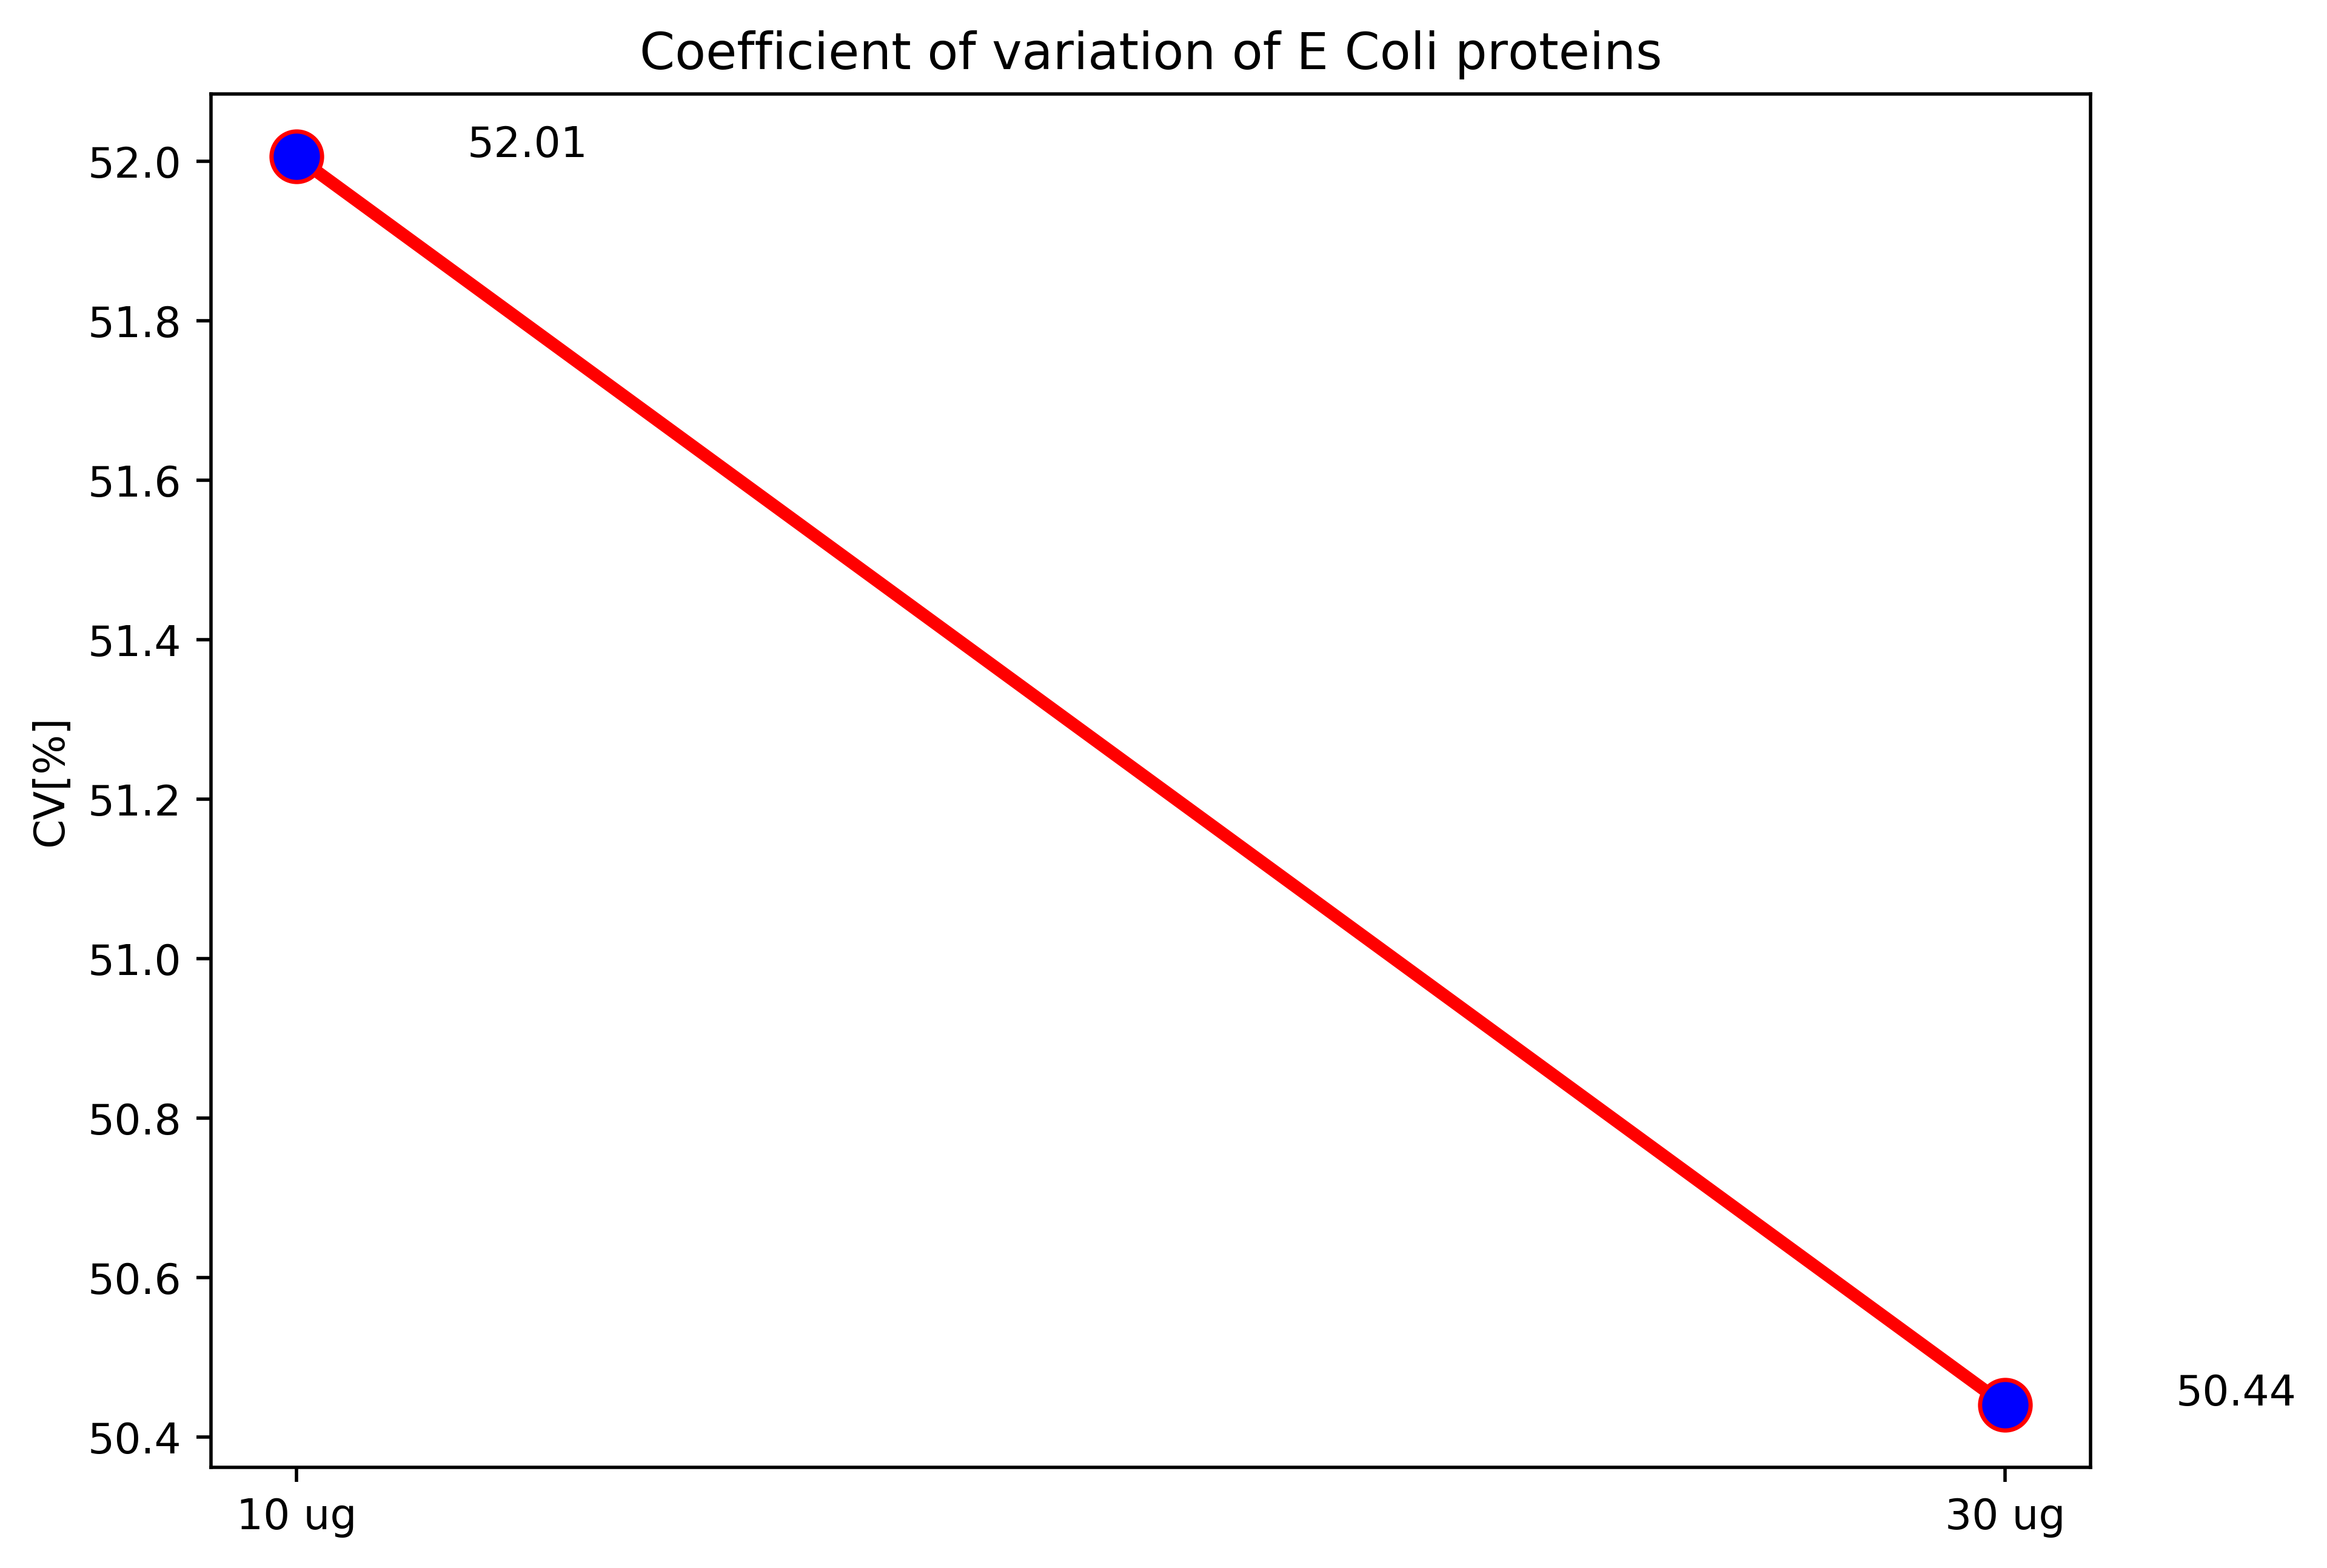

In [7]:
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])

for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("ECOLI")) & (quantms['Condition'] == condition)]

    
    for protein in np.unique(quant_condition['ProteinName']):
        t = quant_condition[quant_condition['ProteinName'] == protein]
        
        # sum intensity across fraction
        if condition == "10 ug":
            TechRep1 = np.sum(t[t['Run'].isin([i for i in range(1,25)])]['Intensity'])
            TechRep2 = np.sum(t[t['Run'].isin([i for i in range(25,49)])]['Intensity'])
            TechRep3 = np.sum(t[t['Run'].isin([i for i in range(49,73)])]['Intensity'])
        else:
            TechRep1 = np.sum(t[t['Run'].isin([i for i in range(73,97)])]['Intensity'])
            TechRep2 = np.sum(t[t['Run'].isin([i for i in range(97,121)])]['Intensity'])
            TechRep3 = np.sum(t[t['Run'].isin([i for i in range(121,145)])]['Intensity'])
            
        mean = np.mean([TechRep1, TechRep2, TechRep3])
        std = np.std([TechRep1, TechRep2, TechRep3])
        n_data = n_data.append({'ProteinName':protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace(" ug", "")))
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    xticks.append(condition)
    
plt.plot(range(2), cvs, linewidth=3, color='r', marker='o',markerfacecolor='blue', markersize=12)
plt.xticks(range(2), xticks)
for i in range(2):
    plt.text(i-0.1, cvs[i], round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of E Coli proteins')
plt.show()

#### Calcaulate CV of HUMAN Proteins

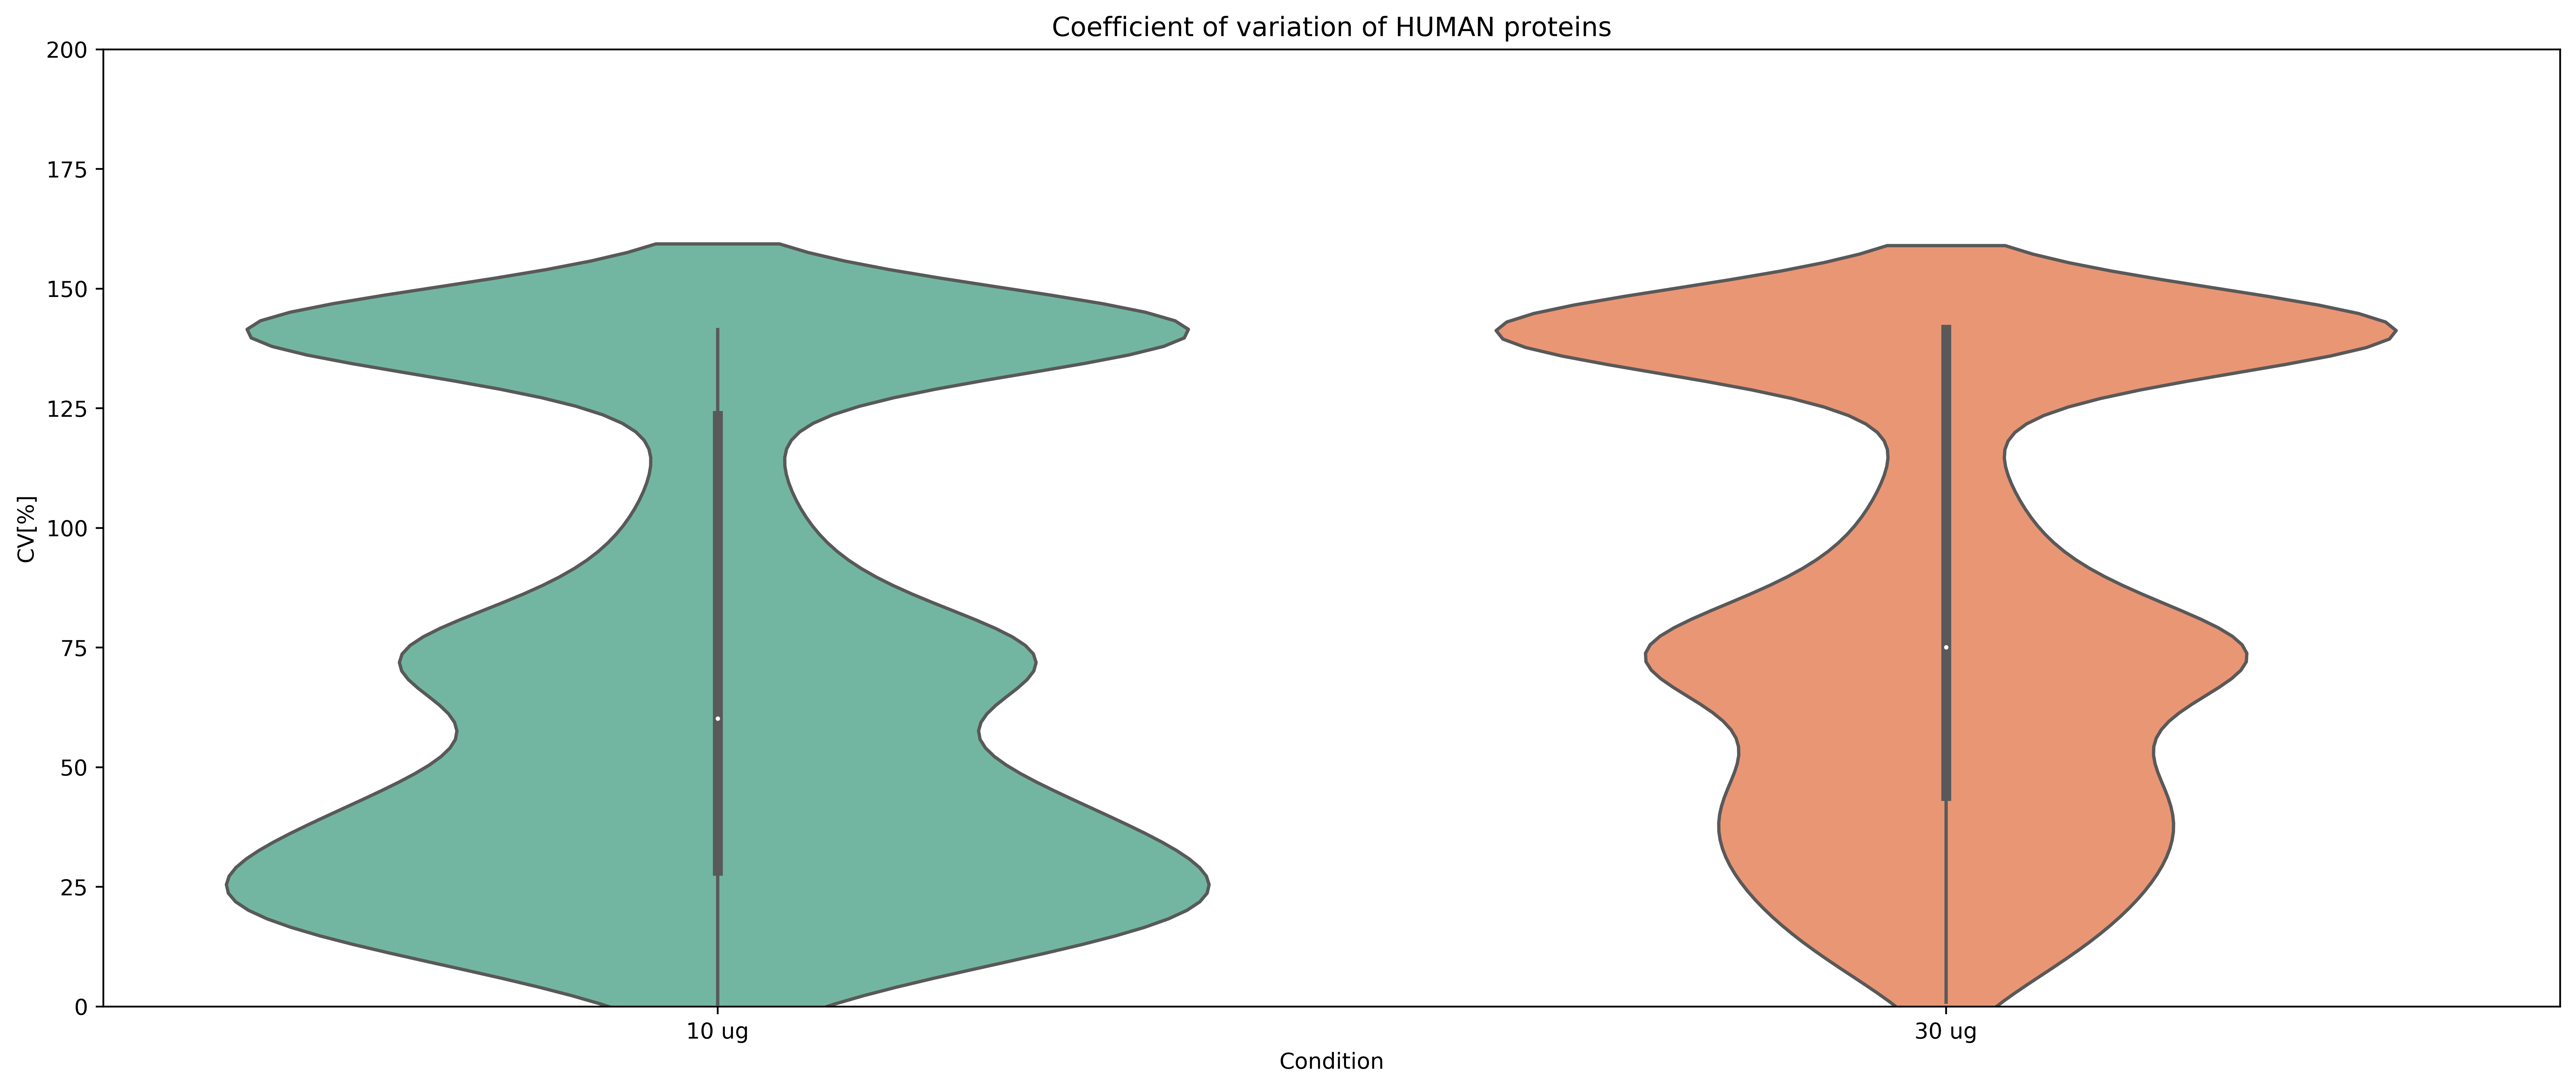

In [9]:
b_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
quantms_background = quantms[quantms['ProteinName'].str.contains("HUMAN")]
for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
        
    for protein in np.unique(quantms_background_condition['ProteinName']):
        t = quantms_background_condition[quantms_background_condition['ProteinName'] == protein]
        
        # sum intensity across fraction
        if condition == "10 ug":
            TechRep1 = np.sum(t[t['Run'].isin([i for i in range(1,25)])]['Intensity'])
            TechRep2 = np.sum(t[t['Run'].isin([i for i in range(25,49)])]['Intensity'])
            TechRep3 = np.sum(t[t['Run'].isin([i for i in range(49,73)])]['Intensity'])
        else:
            TechRep1 = np.sum(t[t['Run'].isin([i for i in range(73,97)])]['Intensity'])
            TechRep2 = np.sum(t[t['Run'].isin([i for i in range(97,121)])]['Intensity'])
            TechRep3 = np.sum(t[t['Run'].isin([i for i in range(121,145)])]['Intensity'])
            
        mean = np.mean([TechRep1, TechRep2, TechRep3])
        std = np.std([TechRep1, TechRep2, TechRep3])
        
        b_data = b_data.append({'ProteinName':protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of HUMAN proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=b_data, scale= "count", palette="Set2", 
               order=['10 ug', '30 ug'])

plt.show()

### QCplots and Calculate FC

In [29]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms['TechReplicate'] = quantms['Reference'].str[-6]
quantms.to_csv("out_msstats_tech.csv", sep=",", index=False)

In [32]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
library("dplyr")
#library(reticulate)

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats_tech.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'linear',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-12-04 20:21:51] ** Multiple fractionations exist: 24 fractionations per MS replicate.
INFO  [2021-12-04 20:23:01] ** Features with one or two measurements across runs are removed.
INFO  [2021-12-04 20:23:01] ** Fractionation handled.
INFO  [2021-12-04 20:23:02] ** Updated quantification data to make balanced design. Missing values are marked by NA


R[write to console]: Aggregate function missing, defaulting to 'length'



INFO  [2021-12-04 20:23:03] ** Use all features that the dataset originally has.
INFO  [2021-12-04 20:23:04] 
 # proteins: 4219
 # peptides per protein: 1-210
 # features per peptide: 1-1
INFO  [2021-12-04 20:23:04] Some proteins have only one feature: 
 sp|O76013|KRT36_HUMAN;sp|O76014|KRT37_HUMAN;sp|O76015|KRT38_HUMAN,
 sp|O95399|UTS2_HUMAN;tr|Q5H8X8|Q5H8X8_HUMAN,
 sp|P0A7P5|RL34_ECOLI,
 sp|P0A7Q1|RL35_ECOLI,
 sp|P0AAF3|ARAG_ECOLI ...
INFO  [2021-12-04 20:23:04] 
                    10 ug 30 ug
             # runs     1     1
    # bioreplicates     1     1
 # tech. replicates     0     0
INFO  [2021-12-04 20:23:04] Some features are completely missing in at least one condition:  
 GLNVMQNLLTAHPDVQAVFAQNDEM(Oxidation)ALGALR_3_NA_0,
 GLNVMQNLLTAHPDVQAVFAQNDEM(Oxidation)ALGALR_4_NA_0,
 VGTLPSHLAALMQTNINVQTLLTEAILTENR_3_NA_0,
 DLVVLLFETALLSSGFSLEDPQTHSNR_4_NA_0,
 LVSSPC(Carbamidomethyl)C(Carbamidomethyl)IVTSTYGWTANM(Oxidation)ER_2_NA_0 ...
INFO  [2021-12-04 20:23:04]  == Start the summar

  |===============================================                       |  67%WARN  [2021-12-04 20:23:48] *** error : can't fit the model for  sp|Q15149|PLEC_HUMAN
WARN  [2021-12-04 20:23:48] *** error : can't fit the model for  sp|Q15545|TAF7_HUMAN
  |===============================================                       |  68%WARN  [2021-12-04 20:23:49] *** error : can't fit the model for  sp|Q16181|SEPT7_HUMAN;tr|A0A0U1RRE1|A0A0U1RRE1_HUMAN;tr|A0A0U1RRH9|A0A0U1RRH9_HUMAN;tr|E7EPK1|E7EPK1_HUMAN;tr|E7ES33|E7ES33_HUMAN;tr|G3V1Q4|G3V1Q4_HUMAN
  |================================================                      |  68%WARN  [2021-12-04 20:23:49] *** error : can't fit the model for  sp|Q16537|2A5E_HUMAN
  |================================================                      |  69%WARN  [2021-12-04 20:23:50] *** error : can't fit the model for  sp|Q46938|KDUI_ECOLI
  |=================================================                     |  69%WARN  [2021-12-04 20:23:50] *** error : can

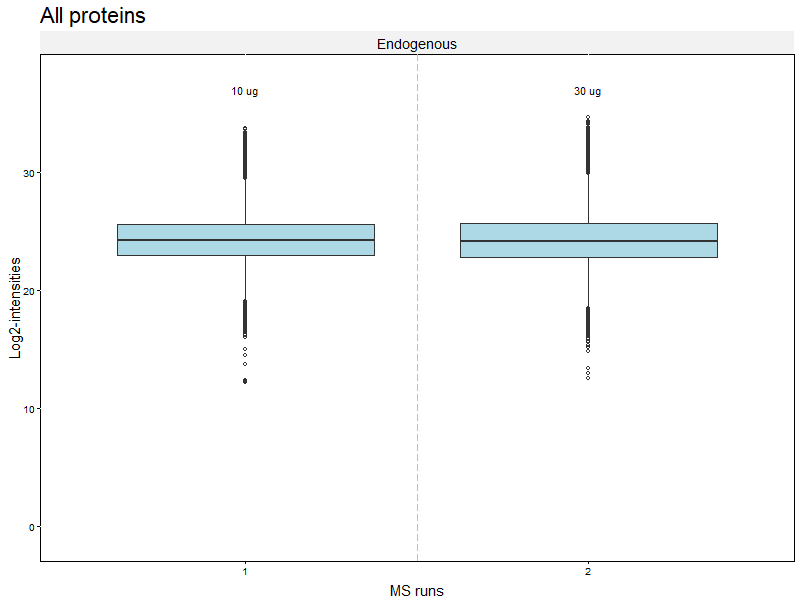

In [33]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [ ]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

#### background proteins: Intensity shoud be identical in all MSrun

In [ ]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [ ]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("P04040ups|CATA_HUMAN_UPS", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [ ]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,0,0,-1,0,0,-1,0,-1,-1,0,0,-1,0,0,-1,0,-1,0,1,0,-1,0,0,-1,0,0,1,1,-1,1,1,1,1,0,0,0,0,0,0,-1,0,0,0,1,1,1,0,0,0)
comparison <- matrix(comparison_matrix, nrow=10)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25")
print(comparison)

In [ ]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

### Measure Accuracy of protein quantification

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected FC - experimental FC / expected FC) * 100. N=number of UPS1 quantified proteins

In [ ]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

In [ ]:
# calculate MAPE
import math

MAPE = []
ups_comp = compar_res[compar_res['Protein'].str.contains("UPS")]
conditions = ["20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25"]
for condition in conditions:
    t = ups_comp[ups_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        experimental_FC = math.pow(2, t[t['Protein'] == protein]['log2FC'])
        expected_FC = float(condition.split("vs")[0]) / float(condition.split("vs")[1])
        ape.append(np.abs(expected_FC - experimental_FC) / expected_FC * 100)
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(10), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(10), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared UPS1 concentration")
plt.ylabel("MAPE")
plt.xticks(rotation=300)
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)；Specifity = TNR = TN / (TN + FN)

In [ ]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('issue != issue')
compar_res

In [ ]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["20vs6.7", "20vs2.2", "20vs0.74","20vs0.25","6.7vs2.2", "6.7vs0.74", "6.7vs0.25","2.2vs0.74", 
                          "2.2vs0.25", "0.74vs0.25"]

data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (group['Protein'].str.contains("UPS"))])
    TP = len(differential_proteins[differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    FP = len(differential_proteins[-differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)